<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/Unet_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from tensorflow.keras import optimizers
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf


In [2]:
def batch_ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
batch_nmse = tf.keras.metrics.RootMeanSquaredError(name='batch_nmse')
def batch_psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))
def batch_msssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim_multiscale(y_true, y_pred, max_val=1.0))


In [3]:
load_data_DIR = "dataset/"
load_data_DIR

'dataset/'

In [4]:
x_train = np.load("{}/x_train.npy".format(load_data_DIR))
y_train = np.load("{}/y_train.npy".format(load_data_DIR))

x_train.shape, y_train.shape

((5504, 320, 320, 1), (5504, 320, 320, 1))

In [5]:
from keras_unet.models import satellite_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [12]:
model = None

def u2():
    model = satellite_unet(input_shape=(320, 320, 1))
    model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='mae', metrics=[batch_ssim, batch_psnr, batch_msssim, batch_nmse])
    return model

In [7]:
def show_slices(data, slice_nums, cmap=None):
    data = data.reshape((data.shape[0], 320,320))
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

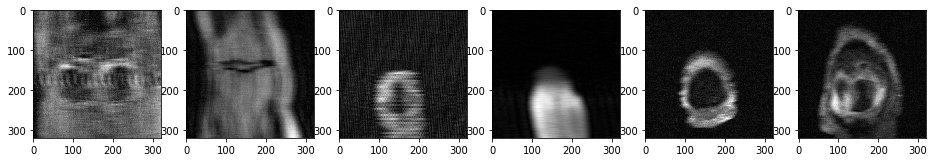

In [8]:
slice_nums = [27, 50, 100, 200, 300, 305]
show_slices(x_train, slice_nums, cmap='gray')

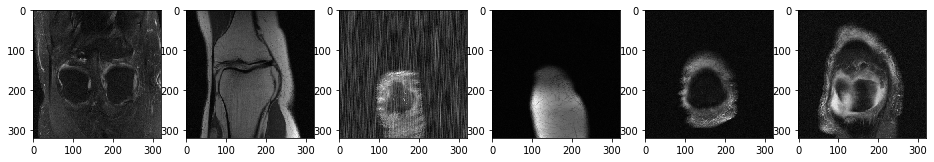

In [9]:
show_slices(y_train, slice_nums, cmap='gray')

In [13]:
model = u2()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 320, 320, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 320, 320, 64) 256         conv2d_28[0][0]                  
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 320, 320, 64) 36928       batch_normalization_31[0][0]     
____________________________________________________________________________________________

In [14]:
h = model.fit(x_train, y_train, validation_split=0.2, batch_size=15, epochs=20)

Epoch 1/20
294/294 [==============================] - 11900s 40s/step - loss: 0.0351 - batch_ssim: 0.8385 - batch_psnr: 45.3437 - batch_msssim: 0.9027 - batch_nmse: 0.1349 - val_loss: 9.4869e-04 - val_batch_ssim: 0.9866 - val_batch_psnr: 57.0814 - val_batch_msssim: 0.9928 - val_batch_nmse: 0.0190
Epoch 2/20
294/294 [==============================] - 12647s 43s/step - loss: 1.9482e-04 - batch_ssim: 0.9998 - batch_psnr: 63.9484 - batch_msssim: 1.0000 - batch_nmse: 9.4126e-04 - val_loss: 1.0160e-04 - val_batch_ssim: 0.9999 - val_batch_psnr: 68.5990 - val_batch_msssim: 1.0000 - val_batch_nmse: 0.0020
Epoch 3/20
294/294 [==============================] - 12877s 44s/step - loss: 7.0634e-05 - batch_ssim: 1.0000 - batch_psnr: 71.0786 - batch_msssim: 1.0000 - batch_nmse: 3.8831e-04 - val_loss: 7.0688e-05 - val_batch_ssim: 0.9996 - val_batch_psnr: 72.2811 - val_batch_msssim: 0.9999 - val_batch_nmse: 0.0033
Epoch 4/20
294/294 [==============================] - 11965s 41s/step - loss: 4.1642e-05 -

In [15]:
model.save("dataset/unet_v1.h5")
print("done ")

done 


In [16]:
h.model.save("h_unet_v2.h5")
print("done")

done


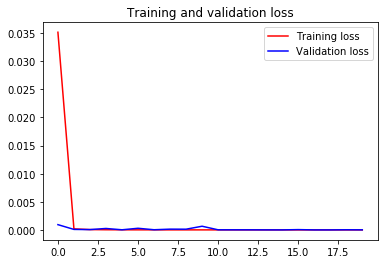

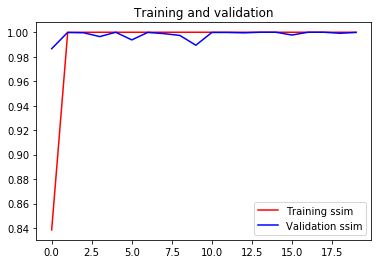

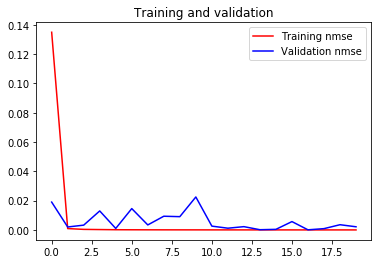

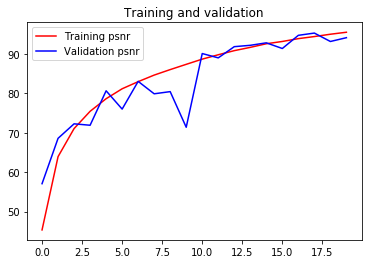

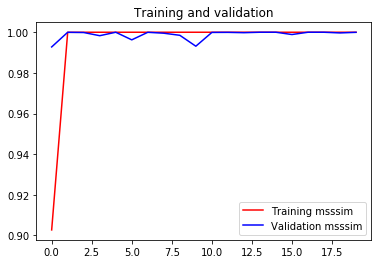

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt

loss = h.history['loss']
val_loss = h.history['val_loss']

ssim = h.history['batch_ssim']
val_ssim = h.history['val_batch_ssim']


nmse = h.history['batch_nmse']
val_nmse = h.history['val_batch_nmse']

psnr = h.history['batch_psnr']
val_psnr = h.history['val_batch_psnr']

msssim = h.history['batch_msssim']
val_msssim = h.history['val_batch_msssim']

epochs = range(len(loss))


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, ssim, 'r', label='Training ssim')
plt.plot(epochs, val_ssim, 'b', label='Validation ssim')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs, nmse, 'r', label='Training nmse')
plt.plot(epochs, val_nmse, 'b', label='Validation nmse')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, psnr, 'r', label='Training psnr')
plt.plot(epochs, val_psnr, 'b', label='Validation psnr')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, msssim, 'r', label='Training msssim')
plt.plot(epochs, val_msssim, 'b', label='Validation msssim')
plt.title('Training and validation')
plt.legend(loc=0)
plt.figure()

plt.show()